In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
np.random.seed(0)

# Data import

In [2]:
path = IMG_PATH/'pixel_squares_images'

In [3]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_py,PRI_tau_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,82655,92,139,106,90,0,0,0,145,130,...,115,98,96,104,92,129,91,0,0,0.000051
1,224745,124,57,126,82,0,0,0,176,104,...,99,93,74,88,158,118,97,0,1,0.000337
2,83843,43,149,52,112,0,0,0,33,189,...,63,80,88,72,90,181,113,0,0,0.000066
3,17480,42,147,50,107,0,0,0,29,180,...,104,109,105,76,92,104,96,85,0,0.000030
4,198311,141,87,121,170,53,76,174,102,158,...,180,97,124,72,189,189,159,170,1,0.000027


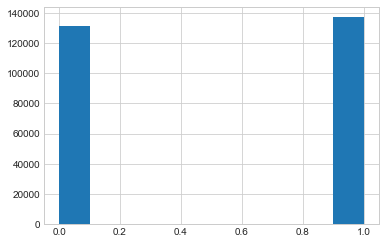

In [4]:
train_df.gen_target.hist()

In [5]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.4895692910394959, 0.510430708960504)

In [6]:
size = 56

In [7]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='image_name',
                              bs=512, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=path, folder='train', suffix='.png').normalize(imagenet_stats)

In [8]:
data

ImageDataBunch;

Train: LabelList (214828 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
0,1,0,0,1
Path: /home/giles/Documents/kaggle/higgsml/pixel_squares_images;

Valid: LabelList (53706 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
0,0,1,0,1
Path: /home/giles/Documents/kaggle/higgsml/pixel_squares_images;

Test: None

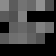

In [9]:
data.train_ds[0][0]

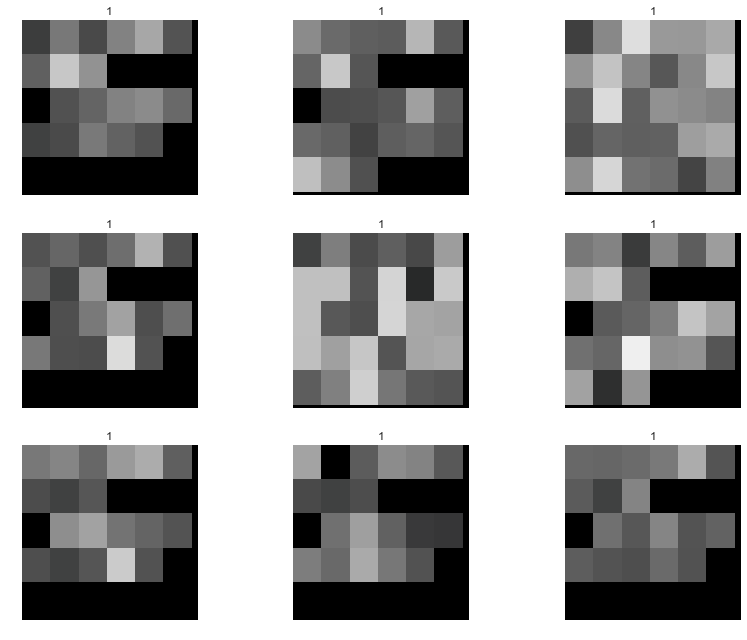

In [10]:
data.show_batch(rows=3, figsize=(12,9))

# Model training

In [11]:
def se_resnet50(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnet50(pretrained=pretrained)
    return model

In [12]:
learn = cnn_learner(data, se_resnet50, pretrained=True, cut=-2, split_on=lambda m: (m[0][3], m[1]), metrics=error_rate)

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (se_module

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


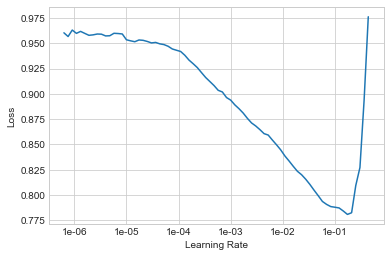

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.432020,0.412969,0.186329,02:22
1,0.407854,0.405048,0.186664,02:21
2,0.385692,0.384710,0.174878,02:20
3,0.371656,0.373537,0.168715,02:21


In [16]:
learn.save('stage-1')

In [22]:
learn.load('stage-1');

In [23]:
learn.unfreeze()

In [24]:
learn.fit_one_cycle(1, max_lr=slice(1e-7,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.363979,0.373103,0.168678,02:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


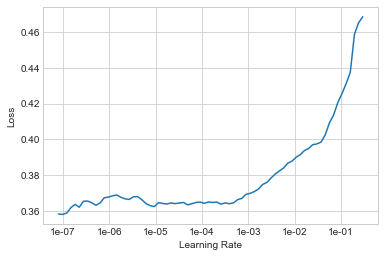

In [25]:
learn.lr_find(1e-8)
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.360539,0.371900,0.168361,02:39
1,0.348382,0.364952,0.163799,02:41
2,0.298643,0.354675,0.153651,02:42
3,0.250810,0.364297,0.150691,02:41


In [21]:
learn.save('stage-2')

In [27]:
learn.load('stage-2');

In [28]:
learn.export()

## Interpretation

### Heatmap
Copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb

In [29]:
x,y = data.valid_ds[1]

In [30]:
m = learn.model.eval();

In [31]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [32]:
from fastai.callbacks.hooks import *

In [33]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [34]:
hook_a,hook_g = hooked_backward()

In [35]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 2, 2])

In [36]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([2, 2])

In [37]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,size,size,0),
              interpolation='bilinear', cmap='magma');

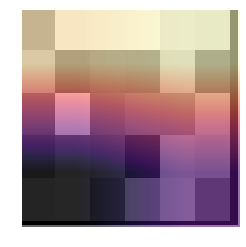

In [38]:
show_heatmap(avg_acts)

### Grad-CAM

In [39]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2048, 2, 2]), torch.Size([2048]))

In [40]:
mult = (acts*grad_chan[...,None,None]).mean(0)

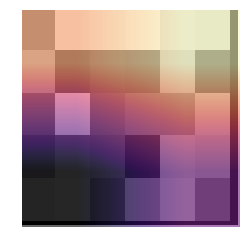

In [41]:
show_heatmap(mult)

# Inference

## Validation

In [42]:
val_df = pd.read_csv(IMG_PATH/'val.csv'); len(val_df); val_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_py,PRI_tau_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,160,60,136,201,0,0,0,90,197,...,131,98,108,166,205,107,176,85,0,0.071357
1,1,126,134,137,76,0,0,0,180,85,...,86,91,117,108,101,113,82,0,1,0.018636
2,2,171,224,198,126,0,0,0,126,81,...,193,71,203,110,64,153,137,85,0,2.394896
3,3,0,179,47,74,0,0,0,30,79,...,65,96,83,88,57,126,147,0,0,4.774053
4,4,137,146,162,75,0,0,0,166,83,...,97,101,156,83,106,95,87,0,0,4.348844


In [43]:
val_lst = ImageList.from_df(val_df, path, folder='val', suffix='.png')

In [44]:
learn = load_learner(path, test=val_lst)

In [45]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [46]:
val_df['pred'] = to_np(multiclass2binary(preds))

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


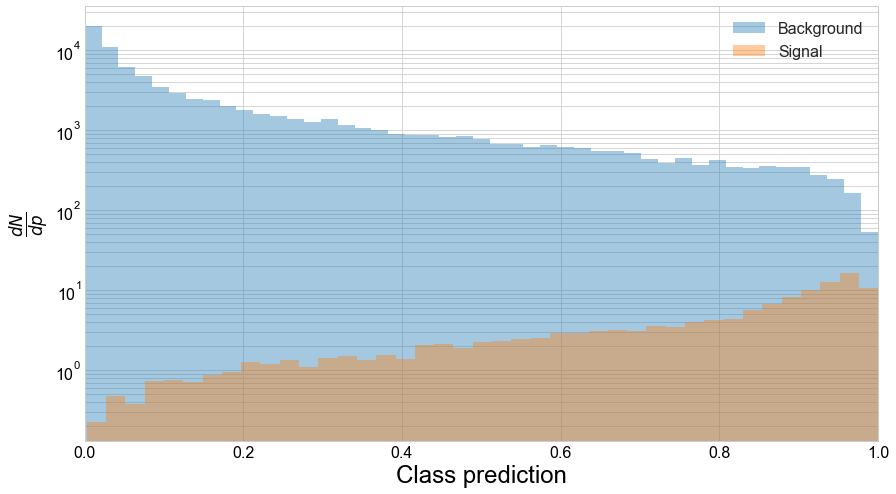

In [47]:
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

Mean cut at 0.9154089093208313 corresponds to AMS of 3.7485736966055287
Maximum AMS for data is 3.8131878365895546 at cut of 0.9233371019363403


/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


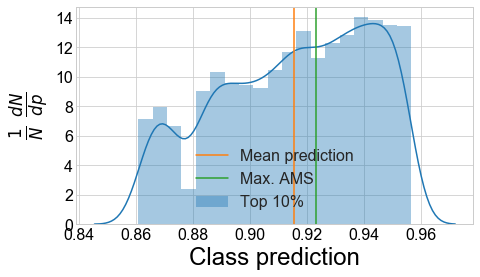

In [48]:
cut, smooth_ams, max_ams = binary_class_cut(val_df, top_perc=10, br=10, wgt_factor=250000/50000, min_pred=0.8)

## Test

In [49]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private
0,0,89,127,104,107,0,0,0,118,81,...,58,75,76,93,146,92,85,0,0.040969,1
1,1,89,76,91,120,0,0,0,112,160,...,201,101,178,161,93,110,85,0,0.932279,1
2,2,98,97,112,76,0,0,0,171,84,...,145,94,88,119,104,74,0,0,4.175975,0
3,3,248,208,252,143,66,84,147,226,243,...,37,178,202,80,203,142,255,0,0.412502,1
4,4,139,178,144,74,0,0,0,184,78,...,81,152,90,84,116,102,0,0,13.118917,0


In [50]:
test_lst = ImageList.from_df(test_df, path, folder='test', suffix='.png')

In [51]:
learn = load_learner(path, test=test_lst)

In [52]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [53]:
test_df['pred'] = to_np(multiclass2binary(preds))

In [54]:
test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,89,127,104,107,0,0,0,118,81,...,75,76,93,146,92,85,0,0.040969,1,0.043472
1,1,89,76,91,120,0,0,0,112,160,...,101,178,161,93,110,85,0,0.932279,1,0.198717
2,2,98,97,112,76,0,0,0,171,84,...,94,88,119,104,74,0,0,4.175975,0,0.770140
3,3,248,208,252,143,66,84,147,226,243,...,178,202,80,203,142,255,0,0.412502,1,0.001182
4,4,139,178,144,74,0,0,0,184,78,...,152,90,84,116,102,0,0,13.118917,0,0.200454


In [55]:
score_test_df(test_df, cut)

Public:Private AMS: 3.4246772062564466 : 3.5489577970229322


(3.4246772062564466, 3.5489577970229322)

In [56]:
score_test_df(test_df, 0.9233371019363403)

Public:Private AMS: 3.3982571200873557 : 3.5311398327848043


(3.3982571200873557, 3.5311398327848043)

In [57]:
from lumin.evaluation.ams import *
from sklearn.model_selection import StratifiedKFold, KFold

In [58]:
ams_scan_quick(test_df[test_df.private==0], br=10), ams_scan_quick(test_df[test_df.private==1], br=10)

((3.488351286309663, 0.8951354622840881),
 (3.553552373008043, 0.914249837398529))

In [59]:
def subsample_score_test(df:pd.DataFrame, cut:Optional[float]=None):
    amss = pd.DataFrame(columns=['Public_AMS', 'Private_AMS', 'Public_Cut', 'Private_Cut'])
    skf = StratifiedKFold(10, True)
    folds = skf.split(df, df.private)
    for _, fold in folds:
        test_fold = test_df.iloc[fold]
        if cut is None:
            public_ams, public_cut = ams_scan_quick(test_fold[test_fold.private==0], br=10, wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]))
            private_ams, private_cut = ams_scan_quick(test_fold[test_fold.private==1], br=10, wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        else:
            public_cut,private_cut = cut,cut 
            public_ams, private_ams = score_test_df(test_fold, cut, verbose=False,
                                                    public_wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]),
                                                    private_wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        amss = amss.append({'Public_AMS':public_ams, 'Private_AMS':private_ams, 'Public_Cut':public_cut, 'Private_Cut':private_cut}, ignore_index=True)
    return amss

In [60]:
results = subsample_score_test(test_df); results

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
0,4.064089,3.371233,0.896003,0.913616
1,3.249780,3.576744,0.862610,0.925116
2,3.906622,3.727960,0.990701,0.944542
3,4.644879,3.738708,0.988617,0.931832
4,3.863442,3.617956,0.980443,0.935167
5,4.005890,3.599177,0.935885,0.899374
6,4.171255,3.681947,0.971929,0.928048
7,4.621866,3.569577,0.991345,0.913854
8,3.886011,3.697579,0.989372,0.953541
9,3.499569,3.629778,0.897878,0.900574


In [61]:
results.describe()

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
count,10.000000,10.000000,10.000000,10.000000
mean,3.991340,3.621066,0.950478,0.924566
std,0.433196,0.106679,0.048627,0.017830
min,3.249780,3.371233,0.862610,0.899374
25%,3.869084,3.582352,0.907380,0.913676
50%,3.956256,3.623867,0.976186,0.926582
75%,4.144463,3.693671,0.989183,0.934333
max,4.644879,3.738708,0.991345,0.953541
